# Assignment 1 task 1
Group 37

## Data dimensionality, distance-based classifiers
From the instructions:  
*The purpose of this task is to develop some intuitions about clouds of points in high-dimensional spaces. In
particular, you are supposed to use dimensionality reduction techniques to visualize your data, develop a
very simple algorithm for classifying hand-written digits and compare it to another distance-based classifier.*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
plt.style.use('mystyle')
# plt.rcParams['image.origin'] = 'lower'
# plt.rcParams['image.aspect'] = 'auto'

### Read training data:
* `train_in` = images of numbers with shape (1706, 256) pixel. 
     * Reshape them from 256 to 16x16 and call the array `train_in_im`
* `train_out` = correct labeling of each image 
    * Convert to array of integers

In [2]:
df_in=pd.read_csv('train_in.csv',header=None)
train_in=df_in.to_numpy()
train_in_im=train_in.reshape(-1,16,16)

df_out=pd.read_csv('train_out.csv',header=None)
train_out=df_out.to_numpy(dtype='int')

print(train_in.shape)
print(train_in_im.shape)
print(train_out.shape)

(1707, 256)
(1707, 16, 16)
(1707, 1)


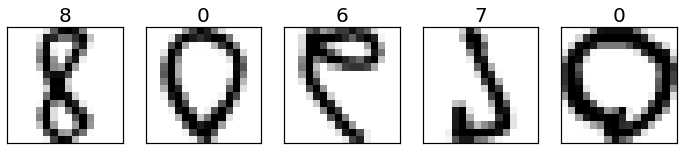

In [3]:
fig, ax = plt.subplots(1,5,figsize=(12,3))

random.seed(1234)
for i in range(len(ax)):
    index=random.randint(0,train_in_im.shape[0]-1)
    ax[i].imshow(-train_in_im[index],cmap='gray')
    ax[i].set_title(train_out[index,0], fontsize=20)
    ax[i].invert_yaxis()
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
plt.show()
fig.savefig('figures/mnist_digits.pdf', dpi=200, bbox_inches='tight')

## 1.1 Group images by number and compute the center
For each digit $d$ ($d = 0,1,...,9$) consider a cloud of points $C_d$ with dimension ($N_d$, 256) where $N_d$ is the number of images beloging to number $d$. For each cloud, we can take the center $c_d$ as the mean over $N_d$, resulting in another 256-dim-vector.  
I define a list containing the clouds for every number: `storm`.

In [4]:
storm = [train_in[np.where(train_out[:,0]==x)] for x in range(0,10)]
centers = [np.mean(storm[x], axis=0) for x in range(0,10)]
# Print how many images of each number we have
print('Number \t:\tN_images')
print('-------------------------')
for n in range(10):
    print('{:2} \t:\t {:3}'.format(n+1, storm[n].shape[0]))

Number 	:	N_images
-------------------------
 1 	:	 319
 2 	:	 252
 3 	:	 202
 4 	:	 131
 5 	:	 122
 6 	:	  88
 7 	:	 151
 8 	:	 166
 9 	:	 144
10 	:	 132


### Calculate distance between the centers

In [5]:
def distance(arr1, arr2):
    return np.sqrt(np.sum(np.power(arr1 - arr2, 2),axis=0))

N = len(storm)
# Set up array to store the distance between pairs
dist = np.zeros((N,N))
# Loop twice to get all the pairs
for i in range(N):
    arr1 = centers[i]
    for j in range(N):
        arr2 = centers[j]
        dist[i,j] = distance(arr1, arr2)

Next we plot the resulting 2D array. The higher the distance the easiest it is to labeling them correctly. We observe that **the pair (1,0) has the highest distance** from the rest while the pairs **{(5,3), (6,5), (9,7)} have the lowest** hence those pairs will be the trickiest.

## 1.2 Experiment with three dimensionality reduction algorithms
* PCA
* UMAP
* T-SNE

In [6]:
df_in=pd.read_csv('test_in.csv',header=None)
test_in=df_in.to_numpy()

df_out=pd.read_csv('test_out.csv',header=None)
test_out=df_out.to_numpy()

MNIST_in=np.concatenate((test_in,train_in),axis=0)
MNIST_out=np.concatenate((test_out,train_out),axis=0)

In [7]:
from sklearn.decomposition import PCA
reducer = PCA(n_components=6)
reducer.fit(MNIST_in)
PCA_reduction_in=reducer.transform(MNIST_in)

import umap
# Initialise reducer
reducer = umap.UMAP(random_state=42)
reducer.fit(MNIST_in)
# Get results
UMAP_reduction_in = reducer.transform(MNIST_in)


from sklearn.manifold import TSNE
reducer=TSNE(n_components=2)
tsne_reduction_in=reducer.fit_transform(MNIST_in)

2022-10-21 13:51:06.078650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 13:51:06.078683: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


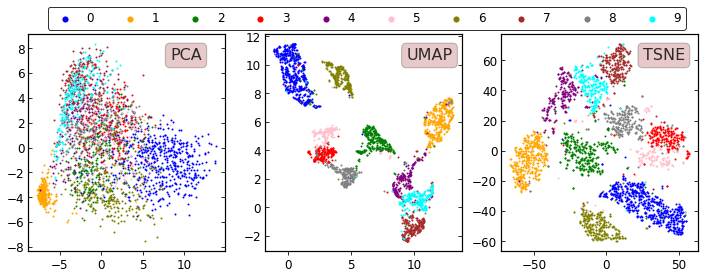

In [8]:
#Plot map
fig, ax = plt.subplots(1,3,figsize=(12,4))

colors=['blue','orange','green','red','purple','pink','olive','brown','gray','cyan']
labels = ['PCA', 'UMAP','TSNE']
props = dict(boxstyle='round', facecolor='brown', alpha=0.25)
for n in range(10):
    for i, alg in enumerate([PCA_reduction_in, UMAP_reduction_in, tsne_reduction_in]):
        local_data=alg[np.where(MNIST_out[:,0]==n)]
        ax[i].scatter(local_data[:,0],local_data[:,1],s=16,linewidths=0,color=colors[n],label=n)
        if n==0:
            ax[i].text(s=labels[i], x=0.72, y=0.88, transform=ax[i].transAxes,
                       fontsize=16, alpha=0.8,bbox=props)

# set one legend
lgnd = ax[2].legend(ncol=len(colors), loc=(-2.3, 1.02), edgecolor='k')
for handle in lgnd.legendHandles:
    handle.set_sizes([150])

plt.show()
# fig.savefig('figures/dim_red_algorithms.pdf')

## 1.3 Euclidean distance classifier

In [9]:
fails=np.array([0 for i in range(10)]) #List of the number of misclassified items
aims=np.array([0 for i in range(10)]) #List of the number of correctly classified items

centers_array=np.array(centers) #Build array from list to ease iteration
confusion_matrix = np.zeros((10,10)) #10x10 map of expected value vs classified value

def classifier(data):
    #Defines the algorithm that classifies the data 
    
    def dist(a,b):
        #Euclidean n-dimensional distance
        return np.sqrt(np.sum((a-b)**2,axis=1))
    
    return np.argmin(dist(centers_array,data))

#Test the algorithm and store the results in the corresponding variables
for i in range(test_in.shape[0]):
    n_pred=classifier(test_in[i,:])
    n_real=test_out[i,0]
    
    if n_pred==n_real:
        aims[n_real]+=1
    else:
        fails[n_real]+=1
    confusion_matrix[n_real,n_pred]+=1

#Calculate the number of correct classifications related to the total number of items
accuracy=aims/(aims+fails)

#Show the results
print('n (real)\tPrecission')
for i in range(accuracy.shape[0]):
    print('{:}\t\t\t{:.0f}%'.format(i,accuracy[i]*100))
    
    
# Euclidean Distance Based Classifier prediction (get matrix)
pred_EDBC = np.array([classifier(test_in[i,:]) for i in range(test_in.shape[0])])


# Plot confusion matrix
# ax = sns.heatmap(confusion_matrix, annot=True, cbar=False)
# ax.set_title('Confusion matrix');

n (real)	Precission
0			79%
1			99%
2			68%
3			77%
4			80%
5			69%
6			87%
7			78%
8			79%
9			77%


## 1.4 K-Nearest-Neighbor

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_in, train_out)

# Get the precicted labels from KNN
pred_KNN = neigh.predict(test_in)
# pred_KNN = neigh.predict(train_in)

# Compare with the expected labels
# precision = pred_KNN == test_out[:,0]
precision = pred_KNN == test_out[:,0]
precision[precision==True].size / pred_KNN.size

/home/dario/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.914

Performance for the training set
n                  EDC                  KNN                 
----------------------------------------------
0                  85%                 100%
1                 100%                 100%
2                  83%                  97%
3                  92%                  98%
4                  78%                  96%
5                  76%                  95%
6                  85%                  99%
7                  84%                  99%
8                  84%                  94%
9                  85%                  96%

Performance for the test set
n                  EDC                  KNN                 
----------------------------------------------
0                  79%                  98%
1                  99%                  98%
2                  68%                  86%
3                  77%                  89%
4                  80%                  91%
5                  69%                  67%
6                

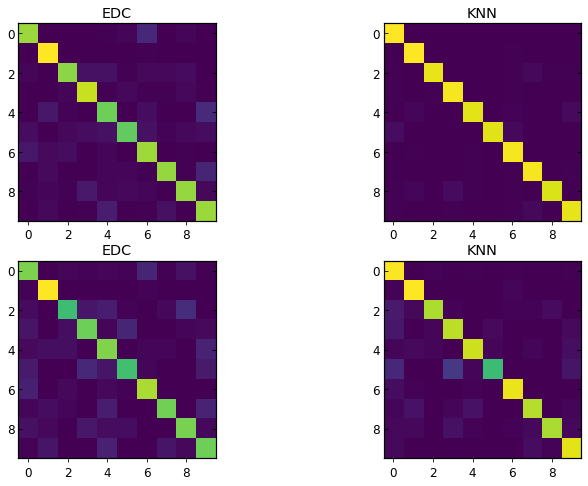

In [13]:
def get_CM(pred, test_out):
    #Build the (percentage) confusion matrix
    CM = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            CM[i,j] = np.intersect1d(np.where(pred==j), np.where(test_out==i)).size / np.where(test_out==i)[0].size       
    return CM

def task_14(data_in, data_out, classifier, neigh, ax=None):
    
    pred_EDC = np.array([classifier(data_in[i,:]) for i in range(data_in.shape[0])])
    pred_KNN = neigh.predict(data_in)

    
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
    
    diag = np.zeros((2, 10))
    labels = ['EDC', 'KNN']
    CM_list = []
    for i,p in enumerate([pred_EDC, pred_KNN]):
        CM = get_CM(p, data_out)
        CM_list.append(CM)
#         sns.heatmap(CM, annot=True, cbar=False, ax=ax[i])
        ax[i].imshow(CM)
        
        ax[i].set_title(labels[i])
        diag[i] = [CM[i,i] for i in range(CM.shape[0])]
        
    
    print('{:18} {:20} {:20}'.format('n', *labels))
    print('----------------------------------------------')
    for i in range(CM.shape[0]):
        print('{:0}{:20.0f}%{:20.0f}%'.format(i,*diag[:,i]*100))
    return CM_list

fig, ax = plt.subplots(2, 2, figsize=(12,8))
print('Performance for the training set')
CM_train = task_14(train_in, train_out, classifier, neigh, ax=ax[0,:])

print('\nPerformance for the test set')
CM_test = task_14(test_in, test_out, classifier, neigh, ax=ax[1,:])
plt.show()

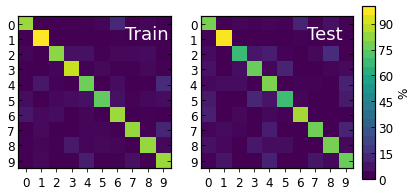

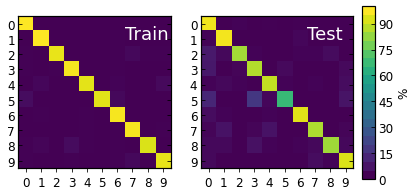

In [14]:
import matplotlib as mpl

def confusion_matrix(CM_list, outname=None):
    fig, ax = plt.subplots(1,2, figsize=(6,3))

    labels = 'Train Test'.split()
    vmin = 0.0
    for i,CM in enumerate(CM_list):
        obj = ax[i].imshow(CM, vmin=vmin, vmax=1)
        ax[i].text(s=labels[i], x=0.70, y=0.85, c='w', transform=ax[i].transAxes, fontsize=18)
        ax[i].set(xticks=np.arange(0,10, dtype=int), yticks=np.arange(0,10, dtype=int))

    cax = plt.axes([0.92, 0.10, 0.03, 0.8])    

    cmap = mpl.cm.viridis

    bounds = np.arange(vmin*100,101, 5, dtype=int)
    # bounds = [-1, 2, 5, 7, 12, 15]

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, label='%')

    # fig.colorbar(obj, cax=cax)
    plt.show()
    if outname is not None:
        fig.savefig('figures/'+outname)
        
# Generate nice figures
confusion_matrix([CM_train[0], CM_test[0]], outname='edbc_confusion_fullrange.pdf')  # EDBC      
confusion_matrix([CM_train[1], CM_test[1]], outname='knn_confusion_fullrange.pdf') # KNN

In [15]:
# Compute the accuracy of each method by measuring the weighted faction of correct classifications
# the weights are the number of samples with that digit, divided by the total amount of samples
def accuracy(CM, data):
    weighted_acc = [CM[i,i] * data[data==i].size / data.size for i in range(10)]
    acc = sum(weighted_acc)
    sigma = np.std(weighted_acc)
    print('Accuracy = {:.2f} +- {:.2f}'.format(acc, sigma))
    return acc, sigma

print('EDBC')
accuracy(CM_test[0], test_out)
print('KNN')
accuracy(CM_test[1], test_out)

EDBC
Accuracy = 0.80 +- 0.04
KNN
Accuracy = 0.91 +- 0.05


(0.9139999999999999, 0.04708120644163656)